In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
from scipy.integrate import quad
from scipy.interpolate import UnivariateSpline
import seaborn as sns
from scipy.special import factorial
import math
from iminuit import cost, Minuit 
import numpy as np
import pickle

sns.set_context('talk', font_scale=1.0)
sns.set_palette('colorblind')

from depth_helpers import *

Cs_line = source_dict['Cs137']

datpath = '/home/cosilab/CalibrationData/CalibratedDATs/'
plot_dir = '/home/cosilab/CalibrationData/figures/postLL2/'
AC_illumination_CTD = '/home/cosilab/CalibrationData/CTDs/Am241_AC_postLL2_57to62keV/CTD_parameters.txt'
DC_illumination_CTD = '/home/cosilab/CalibrationData/CTDs/Am241_DC_postLL2_57to62keV/CTD_parameters.txt'
CTD_sims = '/home/cosilab/COSITrapping/ctd_sims/CTD_HP414183.csv'
AC_sim_events = '/home/cosilab/COSITrapping/ctd_sims/am241_interactions_HP414183_ac.csv'
DC_sim_events = '/home/cosilab/COSITrapping/ctd_sims/am241_interactions_HP414183_dc.csv'
sim_dCCE = '/home/cosilab/COSITrapping/cce_sims/HP414183_dCCE_1000cm.csv'

calibrator = DepthCalibrator_Am241(AC_illumination_CTD, DC_illumination_CTD, AC_sim_events, DC_sim_events, CTD_sims)
sim_depth, sim_ctd = calibrator.get_simdata()

# plt.figure()
# plt.hist(calibrator.AC_sim_CTD + np.random.normal(loc=0.0, scale=21.9, size=calibrator.AC_sim_CTD.shape), bins=100, label='Extra noise')
# plt.hist(calibrator.DC_sim_CTD + np.random.normal(loc=0.0, scale=19.6, size=calibrator.DC_sim_CTD.shape), bins=100, color='C0')
# plt.hist(calibrator.AC_sim_CTD + np.random.normal(loc=0.0, scale=12.0, size=calibrator.AC_sim_CTD.shape), bins=100, histtype='step', color='red', label='Original noise')
# plt.hist(calibrator.DC_sim_CTD + np.random.normal(loc=0.0, scale=12.0, size=calibrator.DC_sim_CTD.shape), bins=100, histtype='step', color='red')
# plt.legend()
# plt.xlabel('CTD (ns)')
# plt.ylabel('Counts')
# plt.tight_layout()
# plt.savefig(plot_dir + 'sim_CTD_noise_comparison.pdf')

/home/cosilab/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/cosilab/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [3]:
file_dict = {'Cs137': [['20231120_Cs137_AC_600V.dat', '20231204_Cs137_AC_600V.dat', '20231206_Cs137_AC_600V.dat', '20231208_Cs137_AC_600V.dat', '20231127_Cs137_AC_600V.dat', '20231205_Cs137_AC_600V.dat', '20231207_Cs137_AC_600V.dat'], \
                       ['20231122_Cs137_DC_600V.dat', '20231129_Cs137_DC_600V.dat', '20231201_Cs137_DC_600V.dat', '20231128_Cs137_DC_600V.dat', '20231130_Cs137_DC_600V.dat', '20231215_Cs137_DC_600V.dat']], \
            'Am241': [['20231212_Am241_AC_600V.dat', '20231213_Am241_AC_600V.dat'], \
                      ['20231214_Am241_DC_600V.dat']]}

erange_dict = {'Cs137': [600., 667.], 'Am241': [50., 64.]}
zbin_dict = {'Cs137': np.linspace(calibrator.zmin, calibrator.zmax, 31), \
             'Am241': np.linspace(calibrator.zmin, calibrator.zmax, 31)}

# Loop and make depth-calibrated dataframes

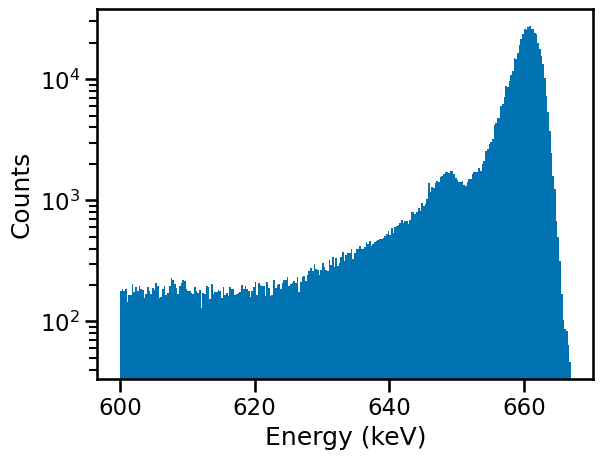

FWHM = 4.34
FWTM = 9.33


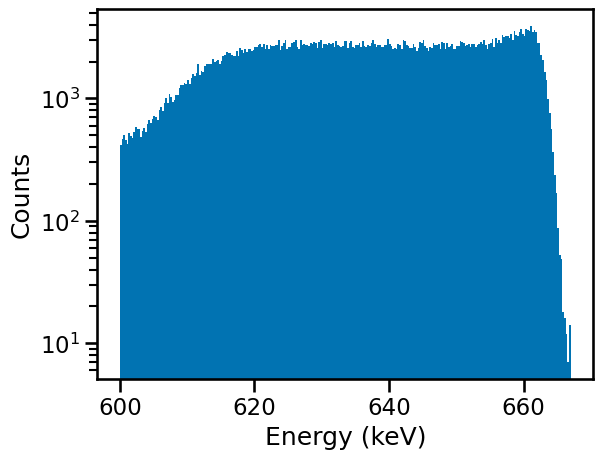

FWHM = 49.28
FWTM = 0.0


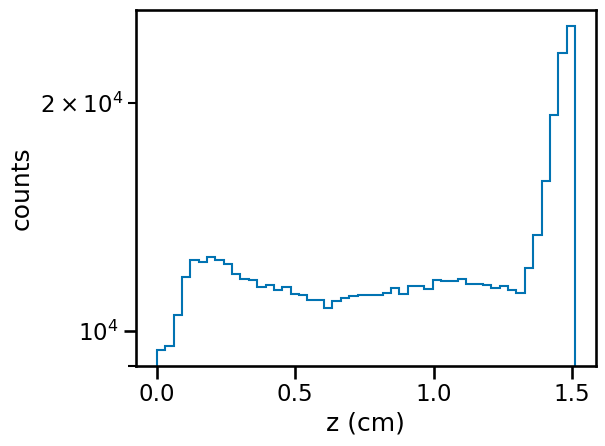

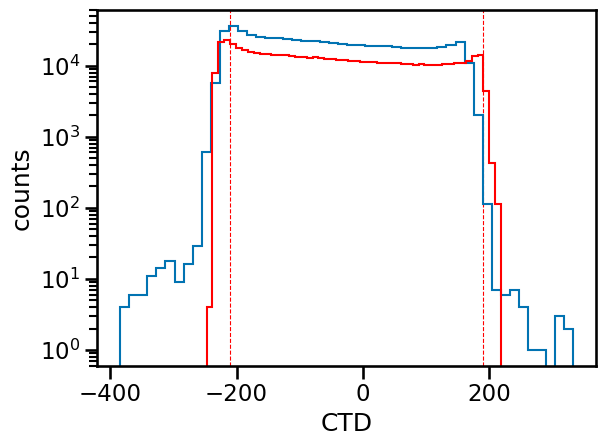

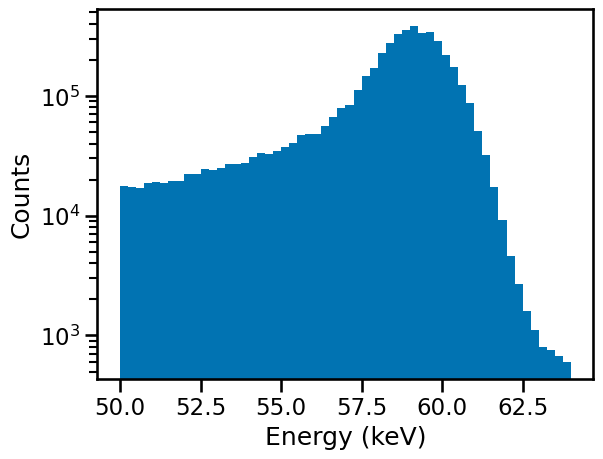

FWHM = 2.31
FWTM = 6.08


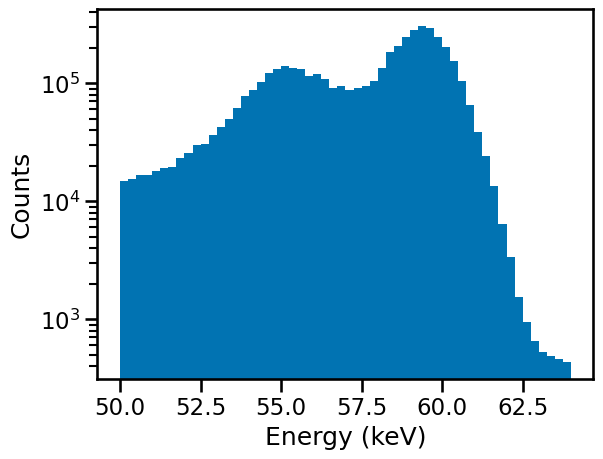

FWHM = 2.18
FWTM = 8.67


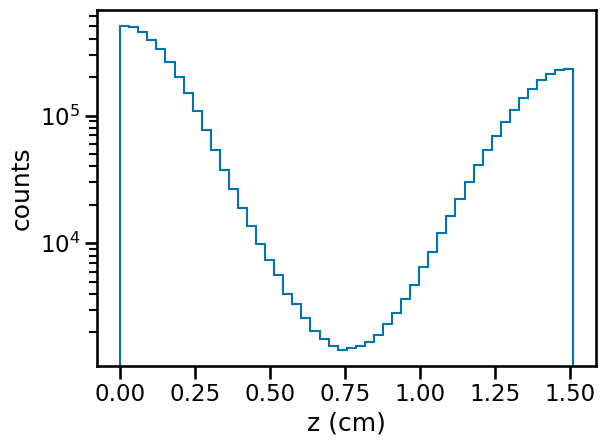

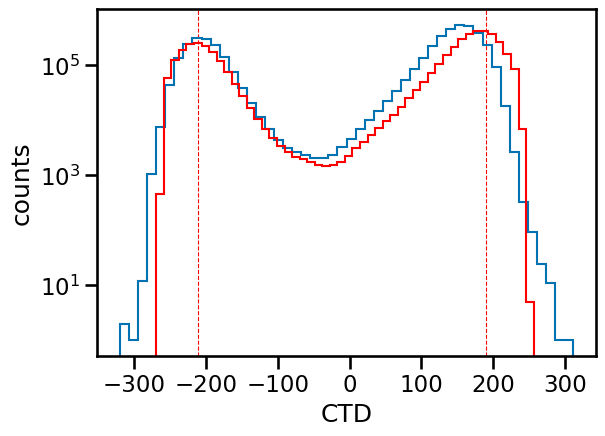

In [4]:
data_dict = {}
for source in file_dict:
    emin = erange_dict[source][0]
    emax = erange_dict[source][1]
    
    string = source + 'allACDC_postLL2'
    
    ## Read in the dat files
    fullpaths = []
    for p in np.concatenate(file_dict[source]):
        fullpaths.append(datpath + 'postLL2/' + p)
    
    df = make_df_from_dat(fullpaths, e_min=emin, e_max=emax)
    bins = int((emax-emin) * 4)
    plt.figure()
    hist,binedges,_  = plt.hist(df['energy_p'], bins=bins, range=(emin, emax))
    plt.yscale('log')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.show()
    
    fwhm_spline = UnivariateSpline(binedges[:-1], hist-0.5*np.max(hist))
    fwtm_spline = UnivariateSpline(binedges[:-1], hist-0.1*np.max(hist))
    fwhm = fwhm_spline.roots()[-1]-fwhm_spline.roots()[0]
    fwtm = fwtm_spline.roots()[-1]-fwtm_spline.roots()[0]
    print('FWHM = ' + str(round(fwhm, 2)))
    print('FWTM = ' + str(round(fwtm, 2)))

    plt.figure()
    hist,binedges,_  = plt.hist(df['energy_n'], bins=binedges)
    plt.yscale('log')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.show()
    
    fwhm_spline = UnivariateSpline(binedges[:-1], hist-0.5*np.max(hist))
    fwtm_spline = UnivariateSpline(binedges[:-1], hist-0.1*np.max(hist))
    fwhm = fwhm_spline.roots()[-1]-fwhm_spline.roots()[0]
    fwtm = fwtm_spline.roots()[-1]-fwtm_spline.roots()[0]
    print('FWHM = ' + str(round(fwhm, 2)))
    print('FWTM = ' + str(round(fwtm, 2)))

    ### Run depth calibration

    ctd_obs_map = [[[] for p in range(37)] for n in range(37)]
    ctd_stretch_map = [[[] for p in range(37)] for n in range(37)]
    ctd_obs_flat = []
    ctd_stretch_flat = []

    for p in range(37):
        for n in range(37):
            ctd_obs, ctd_stretch, depth, depth_err, bad = calibrator.depth_from_timing_prob(p+1, n+1, df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_p'], \
                                                                                       df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_n'], \
                                                                                      df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'energy_p'])
            df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z'] =  depth
            df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z_err'] =  depth_err
            df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'bad'] =  bad
            ctd_obs_map[p][n] = ctd_obs[~bad]
            ctd_stretch_map[p][n] = ctd_stretch[~bad]
            ctd_obs_flat.append(ctd_obs[~bad])
            ctd_stretch_flat.append(ctd_stretch[~bad])

    ctd_obs_flat = np.concatenate(ctd_obs_flat)
    ctd_stretch_flat = np.concatenate(ctd_stretch_flat)
    data_dict[source] = df
    
    plt.figure()
    plt.hist(df["z"], bins=50, histtype = "step", range=(calibrator.zmin,calibrator.zmax))
    plt.yscale('log')
    plt.xlabel("z (cm)")
    plt.ylabel("counts")
    plt.tight_layout()
    plt.savefig(plot_dir + 'depth_' + string + '_prob.pdf')

    plt.figure()
    plt.hist(ctd_obs_flat, bins=50, histtype="step", label="Observed CTD")
    plt.hist(ctd_stretch_flat, bins=50, histtype="step", color='red', label="stretched and shifted")
    plt.axvline(np.max(sim_ctd), lw=0.8, color='red', ls='dashed', zorder=0)
    plt.axvline(np.min(sim_ctd), lw=0.8, color='red', ls='dashed', zorder=0)
    plt.yscale('log')
    plt.xlabel('CTD')
    plt.ylabel('counts')
    plt.tight_layout()
    plt.savefig(plot_dir + "CTD_" + string + ".pdf")

In [5]:
depth_plot_dict = {}
for source in data_dict:
    string = source + 'allACDC_postLL2'
    z_bins, e_trapping, h_trapping = make_depthplot(data_dict[source], string, zbin_dict[source], source=source)
    depth_plot_dict[source] = z_bins, e_trapping, h_trapping
    depth_correction(data_dict[source], z_bins, e_trapping, h_trapping, plot_suffix = string, source = source)
    with open('./depth_plot_'+string+'.txt', 'wb') as file:
        pickle.dump([z_bins, e_trapping, h_trapping], file)

/home/cosilab/COSITrapping/depth_helpers.py:58: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad(gauss_plus_tail, Emin, Emax, args=(BoverA, x0, sigma_gauss, gamma, CoverB, D, sigma_ratio))[0]


FWHM = 3.89+/-0.004
FWTM = 9.051+/-0.008
FWHM = 3.543+/-0.003
FWTM = 8.015+/-0.008
FWHM = 0.0+/-0.0
FWTM = 0.0+/-0.0
FWHM = 6.509+/-0.006
FWTM = 17.428+/-0.017
FWHM = 2.488+/-0.001
FWTM = 6.303+/-0.002
FWHM = 2.477+/-0.001
FWTM = 6.38+/-0.002
FWHM = 2.157+/-0.001
FWTM = 8.797+/-0.003


/home/cosilab/miniconda3/lib/python3.11/site-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


FWHM = 2.531+/-0.001
FWTM = 5.585+/-0.002


In [6]:
param_dict = {}
for source in data_dict:
    string = source + 'allACDC_postLL2'
    m = fit_CCE(*depth_plot_dict[source], sim_dCCE, plot_suffix = string, trim_index = 1, source=source)
    depth_correction_CCE(data_dict[source], *m.values['ae','ah','b','c'], sim_dCCE, plot_suffix = string, source=source)
    param_dict[source] = m
    print(m)

FWHM = 3.827+/-0.004
FWTM = 8.921+/-0.008
FWHM = 3.719+/-0.003
FWTM = 8.203+/-0.008
FWHM = 0.0+/-0.0
FWTM = 0.0+/-0.0
FWHM = 7.747+/-0.008
FWTM = 0.0+/-0.0
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 6.381e+05 (chi2/ndof = 12270.8)│              Nfcn = 355              │
│ EDM = 7.94e-05 (Goal: 0.0002)    │            time = 0.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───

/home/cosilab/miniconda3/lib/python3.11/site-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


FWHM = 2.253+/-0.001
FWTM = 6.068+/-0.002
FWHM = 2.004+/-0.001
FWTM = 11.008+/-0.004
FWHM = 2.399+/-0.001
FWTM = 5.432+/-0.002
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.269e+04 (chi2/ndof = 628.7)│              Nfcn = 268              │
│ EDM = 3.54e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────

In [7]:
for source in data_dict:
    string = source + 'allACDC_postLL2_Cs137params'
    depth_correction_CCE(data_dict[source], *param_dict[source].values['ae','ah'], *param_dict['Cs137'].values['b','c'], sim_dCCE, plot_suffix = string, source=source)

FWHM = 3.827+/-0.004
FWTM = 8.921+/-0.008
FWHM = 3.719+/-0.003
FWTM = 8.203+/-0.008
FWHM = 0.0+/-0.0
FWTM = 0.0+/-0.0
FWHM = 7.747+/-0.008
FWTM = 0.0+/-0.0
FWHM = 2.279+/-0.001
FWTM = 6.148+/-0.002


/home/cosilab/miniconda3/lib/python3.11/site-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


FWHM = 2.339+/-0.001
FWTM = 6.471+/-0.002
FWHM = 2.004+/-0.001
FWTM = 11.008+/-0.004
FWHM = 2.381+/-0.001
FWTM = 5.428+/-0.002


In [8]:
trim_index = 1
sim_dCCE_dat = np.loadtxt(sim_dCCE, delimiter=',').T

def e_depth_plot_Cs(z, ae_Cs, b, c):
    CCE = ae_Cs*(1.-b*sim_dCCE_dat[1][::-1])*(1.-c*sim_dCCE_dat[2][::-1])
    return UnivariateSpline(sim_dCCE_dat[0], CCE)(z)

def h_depth_plot_Cs(z, ah_Cs, b, c):
    CCE = ah_Cs*(1.-b*sim_dCCE_dat[3][::-1])*(1.-c*sim_dCCE_dat[4][::-1])
    return UnivariateSpline(sim_dCCE_dat[0], CCE)(z)

In [11]:
func_dict = {'Cs137': [e_depth_plot_Cs, h_depth_plot_Cs]}

c = cost.Constant(0.0)

for source in ['Cs137']:
    
    z_bins, e_trapping, h_trapping = depth_plot_dict[source]
    z_list = (z_bins[:-1] + z_bins[1:])/2.
    z_err = (z_bins[1:]-z_bins[:-1])/2.
    
    c += cost.LeastSquares(z_list[trim_index:-trim_index], e_trapping[0][trim_index:-trim_index], e_trapping[1][trim_index:-trim_index], func_dict[source][0]) + \
    cost.LeastSquares(z_list[trim_index:-trim_index], h_trapping[0][trim_index:-trim_index], 1.0e-3, func_dict[source][1])

m = Minuit(c, ae_Cs=1.0, ah_Cs=1.0, b=1.365, c=30.)
m.limits["b", "c"] = (0, None)
m.fixed["b"] = True
m.migrad()
m.hesse()
m.minos()
print(m)

for source in ['Cs137']:
    
    z_bins, e_trapping, h_trapping = depth_plot_dict[source]
    z_list = (z_bins[:-1] + z_bins[1:])/2.
    z_err = (z_bins[1:]-z_bins[:-1])/2.

    
    plot_suffix = source + 'allACDC_postLL2'
    line_e = source_dict[source]
    
    plt.figure()

    plt.errorbar(z_list[trim_index:-trim_index], e_trapping[0][trim_index:-trim_index]*line_e, xerr = z_err[trim_index:-trim_index], yerr=e_trapping[1][trim_index:-trim_index]*line_e, fmt=".", label="HV signal")
    plt.errorbar(z_list[trim_index:-trim_index], h_trapping[0][trim_index:-trim_index]*line_e, xerr = z_err[trim_index:-trim_index], yerr=h_trapping[1][trim_index:-trim_index]*line_e, fmt=".", label="LV signal")
    plt.errorbar(z_list[:trim_index], e_trapping[0][:trim_index]*line_e, xerr = z_err[:trim_index], yerr=e_trapping[1][:trim_index]*line_e, fmt="x", color='C0')
    plt.errorbar(z_list[:trim_index], h_trapping[0][:trim_index]*line_e, xerr = z_err[:trim_index], yerr=h_trapping[1][:trim_index]*line_e, fmt="x", color='C1')
    plt.errorbar(z_list[-trim_index:], e_trapping[0][-trim_index:]*line_e, xerr = z_err[-trim_index:], yerr=e_trapping[1][-trim_index:]*line_e, fmt="x", color='C0')
    plt.errorbar(z_list[-trim_index:], h_trapping[0][-trim_index:]*line_e, xerr = z_err[-trim_index:], yerr=h_trapping[1][-trim_index:]*line_e, fmt="x", color='C1')


    plt.plot(sim_dCCE_dat[0], func_dict[source][0](sim_dCCE_dat[0], *m.values['ae_'+source[:2], 'b', 'c'])*line_e, color='C0', zorder=0, lw=0.9)
    plt.plot(sim_dCCE_dat[0], func_dict[source][1](sim_dCCE_dat[0], *m.values['ah_'+source[:2], 'b', 'c'])*line_e, color='C1', zorder=0, lw=0.9)

    plt.axhline(line_e, ls='--', color='C2', zorder=0)
    plt.legend()
    plt.xlabel("Detector Depth (cm)"); plt.ylabel("Centroid Energy (keV)")
    plt.tight_layout()
    plt.savefig(plot_dir + 'CCE_fit_frozenb_energy_' + plot_suffix + '.pdf')
    # plt.savefig(plot_dir + 'CCE_fit_energy_' + plot_suffix + '.pdf')
    plt.close()

    plt.figure()

    plt.errorbar(z_list[trim_index:-trim_index], e_trapping[0][trim_index:-trim_index]/m.values['ae_'+source[:2]], xerr = z_err[trim_index:-trim_index], yerr=e_trapping[1][trim_index:-trim_index]/m.values['ae_'+source[:2]], fmt=".", label="HV signal")
    plt.errorbar(z_list[trim_index:-trim_index], h_trapping[0][trim_index:-trim_index]/m.values['ah_'+source[:2]], xerr = z_err[trim_index:-trim_index], yerr=h_trapping[1][trim_index:-trim_index]/m.values['ah_'+source[:2]], fmt=".", label="LV signal")
    plt.errorbar(z_list[:trim_index], e_trapping[0][:trim_index]/m.values['ae_'+source[:2]], xerr = z_err[:trim_index], yerr=e_trapping[1][:trim_index]/m.values['ae_'+source[:2]], fmt="x", color='C0')
    plt.errorbar(z_list[:trim_index], h_trapping[0][:trim_index]/m.values['ah_'+source[:2]], xerr = z_err[:trim_index], yerr=h_trapping[1][:trim_index]/m.values['ah_'+source[:2]], fmt="x", color='C1')
    plt.errorbar(z_list[-trim_index:], e_trapping[0][-trim_index:]/m.values['ae_'+source[:2]], xerr = z_err[-trim_index:], yerr=e_trapping[1][-trim_index:]/m.values['ae_'+source[:2]], fmt="x", color='C0')
    plt.errorbar(z_list[-trim_index:], h_trapping[0][-trim_index:]/m.values['ah_'+source[:2]], xerr = z_err[-trim_index:], yerr=h_trapping[1][-trim_index:]/m.values['ah_'+source[:2]], fmt="x", color='C1')

    plt.plot(sim_dCCE_dat[0], func_dict[source][0](sim_dCCE_dat[0], *m.values['ae_'+source[:2], 'b', 'c'])/m.values['ae_'+source[:2]], color='C0', zorder=0, lw=0.9)
    plt.plot(sim_dCCE_dat[0], func_dict[source][1](sim_dCCE_dat[0], *m.values['ah_'+source[:2], 'b', 'c'])/m.values['ah_'+source[:2]], color='C1', zorder=0, lw=0.9)

    plt.legend()
    plt.xlabel("Detector Depth (cm)")
    plt.ylabel("CCE")
    plt.ylim(top=1.0)
    plt.tight_layout()
    plt.savefig(plot_dir + 'CCE_fit_frozenb_norm_' + plot_suffix + '.pdf')
    # plt.savefig(plot_dir + 'CCE_fit_norm_' + plot_suffix + '.pdf')
    plt.close()
    # depth_correction_CCE(data_dict[source], *m.values['ae','ah','b','c'], sim_dCCE, plot_suffix = string, source=source)
    # param_dict[source] = m

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2588 (chi2/ndof = 48.8)    │              Nfcn = 160              │
│ EDM = 1.11e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬─────

In [10]:
func_dict = {'Cs137': [e_depth_plot_Cs, h_depth_plot_Cs]}

c = cost.Constant(0.0)

for source in ['Cs137']:
    
    z_bins, e_trapping, h_trapping = depth_plot_dict[source]
    z_list = (z_bins[:-1] + z_bins[1:])/2.
    z_err = (z_bins[1:]-z_bins[:-1])/2.
    
    c += cost.LeastSquares(z_list[trim_index:-trim_index], e_trapping[0][trim_index:-trim_index], e_trapping[1][trim_index:-trim_index], func_dict[source][0]) + \
    cost.LeastSquares(z_list[trim_index:-trim_index], h_trapping[0][trim_index:-trim_index], 1.0e-3, func_dict[source][1])

m = Minuit(c, ae_Cs=1.0, ah_Cs=1.0, b=1.38, c=30.)
m.limits["b", "c"] = (0, None)

m.migrad()
m.hesse()
m.minos()
print(m)

for source in ['Cs137']:
    
    z_bins, e_trapping, h_trapping = depth_plot_dict[source]
    z_list = (z_bins[:-1] + z_bins[1:])/2.
    z_err = (z_bins[1:]-z_bins[:-1])/2.

    
    plot_suffix = source + 'allACDC_postLL2'
    line_e = source_dict[source]
    
    plt.figure()

    plt.errorbar(z_list[trim_index:-trim_index], e_trapping[0][trim_index:-trim_index]*line_e, xerr = z_err[trim_index:-trim_index], yerr=e_trapping[1][trim_index:-trim_index]*line_e, fmt=".", label="HV signal")
    plt.errorbar(z_list[trim_index:-trim_index], h_trapping[0][trim_index:-trim_index]*line_e, xerr = z_err[trim_index:-trim_index], yerr=h_trapping[1][trim_index:-trim_index]*line_e, fmt=".", label="LV signal")
    plt.errorbar(z_list[:trim_index], e_trapping[0][:trim_index]*line_e, xerr = z_err[:trim_index], yerr=e_trapping[1][:trim_index]*line_e, fmt="x", color='C0')
    plt.errorbar(z_list[:trim_index], h_trapping[0][:trim_index]*line_e, xerr = z_err[:trim_index], yerr=h_trapping[1][:trim_index]*line_e, fmt="x", color='C1')
    plt.errorbar(z_list[-trim_index:], e_trapping[0][-trim_index:]*line_e, xerr = z_err[-trim_index:], yerr=e_trapping[1][-trim_index:]*line_e, fmt="x", color='C0')
    plt.errorbar(z_list[-trim_index:], h_trapping[0][-trim_index:]*line_e, xerr = z_err[-trim_index:], yerr=h_trapping[1][-trim_index:]*line_e, fmt="x", color='C1')


    plt.plot(sim_dCCE_dat[0], func_dict[source][0](sim_dCCE_dat[0], *m.values['ae_'+source[:2], 'b', 'c'])*line_e, color='C0', zorder=0, lw=0.9)
    plt.plot(sim_dCCE_dat[0], func_dict[source][1](sim_dCCE_dat[0], *m.values['ah_'+source[:2], 'b', 'c'])*line_e, color='C1', zorder=0, lw=0.9)

    plt.axhline(line_e, ls='--', color='C2', zorder=0)
    plt.legend()
    plt.xlabel("Detector Depth (cm)"); plt.ylabel("Centroid Energy (keV)")
    plt.tight_layout()
    plt.savefig(plot_dir + 'CCE_fit_energy_' + plot_suffix + '.pdf')
    plt.close()

    plt.figure()

    plt.errorbar(z_list[trim_index:-trim_index], e_trapping[0][trim_index:-trim_index]/m.values['ae_'+source[:2]], xerr = z_err[trim_index:-trim_index], yerr=e_trapping[1][trim_index:-trim_index]/m.values['ae_'+source[:2]], fmt=".", label="HV signal")
    plt.errorbar(z_list[trim_index:-trim_index], h_trapping[0][trim_index:-trim_index]/m.values['ah_'+source[:2]], xerr = z_err[trim_index:-trim_index], yerr=h_trapping[1][trim_index:-trim_index]/m.values['ah_'+source[:2]], fmt=".", label="LV signal")
    plt.errorbar(z_list[:trim_index], e_trapping[0][:trim_index]/m.values['ae_'+source[:2]], xerr = z_err[:trim_index], yerr=e_trapping[1][:trim_index]/m.values['ae_'+source[:2]], fmt="x", color='C0')
    plt.errorbar(z_list[:trim_index], h_trapping[0][:trim_index]/m.values['ah_'+source[:2]], xerr = z_err[:trim_index], yerr=h_trapping[1][:trim_index]/m.values['ah_'+source[:2]], fmt="x", color='C1')
    plt.errorbar(z_list[-trim_index:], e_trapping[0][-trim_index:]/m.values['ae_'+source[:2]], xerr = z_err[-trim_index:], yerr=e_trapping[1][-trim_index:]/m.values['ae_'+source[:2]], fmt="x", color='C0')
    plt.errorbar(z_list[-trim_index:], h_trapping[0][-trim_index:]/m.values['ah_'+source[:2]], xerr = z_err[-trim_index:], yerr=h_trapping[1][-trim_index:]/m.values['ah_'+source[:2]], fmt="x", color='C1')

    plt.plot(sim_dCCE_dat[0], func_dict[source][0](sim_dCCE_dat[0], *m.values['ae_'+source[:2], 'b', 'c'])/m.values['ae_'+source[:2]], color='C0', zorder=0, lw=0.9)
    plt.plot(sim_dCCE_dat[0], func_dict[source][1](sim_dCCE_dat[0], *m.values['ah_'+source[:2], 'b', 'c'])/m.values['ah_'+source[:2]], color='C1', zorder=0, lw=0.9)

    plt.legend()
    plt.xlabel("Detector Depth (cm)")
    plt.ylabel("CCE")
    plt.ylim(top=1.0)
    plt.tight_layout()
    plt.savefig(plot_dir + 'CCE_fit_norm_' + plot_suffix + '.pdf')
    plt.close()


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2559 (chi2/ndof = 49.2)    │              Nfcn = 285              │
│ EDM = 3.04e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬─────